## Introduction
To determine where my friends and I should meet up, I have prepared this analysis. The analysis assumes automobile travel, to perform a similar analysis for public transport, you'll need a [Google Maps API key](https://developers.google.com/maps/) and to make a tiny change to the code.

This is deceptively simple. We will be creating a distance matrix with the Google Maps API and then doing a multiply and accumulate 😆.

## Method

First import some libraries

In [1]:
import pandas as pd
import requests
import datetime

Now we need to establish the location of individuals who will be attending the fabulous event.

In [2]:
homes = [
     ['Mike', 'Kaiserslautern, Germany'],
     ['Smash', 'Kaiserslautern, Germany'],
     ['Yawn', 'Kaiserslautern, Germany'],
     ['Therese', 'Kaiserslautern, Germany'],
     ['Dannyboy', 'Frankfurt, Germany'],
     ['Matador', 'Frankfurt, Germany'],
     ['Karabiner', 'Aachen, Germany'],
     ['Matty', 'Aachen, Germany'],
     ['Flow', 'Stuttgart, Germany']
        ]

Create a dataframe from the list.

In [3]:
homes = pd.DataFrame(homes, columns=['person', 'home'])
homes

,person,home
0,Mike,"Kaiserslautern, Germany"
1,Smash,"Kaiserslautern, Germany"
2,Yawn,"Kaiserslautern, Germany"
3,Therese,"Kaiserslautern, Germany"
4,Dannyboy,"Frankfurt, Germany"
5,Matador,"Frankfurt, Germany"
6,Karabiner,"Aachen, Germany"
7,Matty,"Aachen, Germany"
8,Flow,"Stuttgart, Germany"


The set of destinations can be the same as the set of homes.

In [4]:
all_homes = homes.home.unique()
destinations = all_homes

Build a URL for the google [distance matrix API](https://developers.google.com/maps/documentation/distance-matrix/intro#travel_modes).

In [5]:
params = [
    f'origins={"|".join(destinations)}',
    f'destinations={"|".join(destinations)}',
    f'mode=car', # comment this and uncomment below for public transport
    # f'mode=transit',
    # f'key={api_key}',
]
params = '&'.join(params)

In [6]:
url = f'https://maps.googleapis.com/maps/api/distancematrix/json?{params}'
url

'https://maps.googleapis.com/maps/api/distancematrix/json?origins=Kaiserslautern, Germany|Frankfurt, Germany|Aachen, Germany|Stuttgart, Germany&destinations=Kaiserslautern, Germany|Frankfurt, Germany|Aachen, Germany|Stuttgart, Germany&mode=car'

Fetch the URL and put the result into a Data Frame.

In [7]:
r = requests.get(url)
content = r.json()
content

{'destination_addresses': ['Kaiserslautern, Germany',
  'Frankfurt, Germany',
  'Aachen, Germany',
  'Stuttgart, Germany'],
 'origin_addresses': ['Kaiserslautern, Germany',
  'Frankfurt, Germany',
  'Aachen, Germany',
  'Stuttgart, Germany'],
 'rows': [{'elements': [{'distance': {'text': '1 m', 'value': 0},
     'duration': {'text': '1 min', 'value': 0},
     'status': 'OK'},
    {'distance': {'text': '118 km', 'value': 118039},
     'duration': {'text': '1 hour 25 mins', 'value': 5123},
     'status': 'OK'},
    {'distance': {'text': '289 km', 'value': 289084},
     'duration': {'text': '2 hours 55 mins', 'value': 10477},
     'status': 'OK'},
    {'distance': {'text': '197 km', 'value': 197209},
     'duration': {'text': '2 hours 6 mins', 'value': 7531},
     'status': 'OK'}]},
  {'elements': [{'distance': {'text': '118 km', 'value': 117855},
     'duration': {'text': '1 hour 26 mins', 'value': 5180},
     'status': 'OK'},
    {'distance': {'text': '1 m', 'value': 0},
     'duration'

In [8]:
distance_matrix = [
    [datetime.timedelta(seconds=dest['duration']['value']) 
                    for dest in row['elements']] 
                   for row in content['rows']]

In [9]:
travel_times = pd.DataFrame(
    distance_matrix,
    columns=content['destination_addresses'],
    index=content['origin_addresses']
)

In [10]:
travel_times

,"Kaiserslautern, Germany","Frankfurt, Germany","Aachen, Germany","Stuttgart, Germany"
"Kaiserslautern, Germany",00:00:00,01:25:23,02:54:37,02:05:31
"Frankfurt, Germany",01:26:20,00:00:00,02:40:31,02:12:32
"Aachen, Germany",02:55:44,02:42:19,00:00:00,04:10:31
"Stuttgart, Germany",02:08:37,02:15:07,04:11:28,00:00:00


Write a function that will sum all of the individual travel times to create a 'total travel time' for a given destination.

In [11]:
def total_travel_time(destination):
    dest_times = travel_times[destination].sort_index()
    counts = homes.groupby('home').count().sort_index()
    counts.index.name = None
    person_times = dest_times * counts.person
    return person_times.sum()

Create another DataFrame with the total accumulated travel time for each destination.

In [12]:
total_travel_times = list(map(total_travel_time, destinations))

In [13]:
tt_df = pd.DataFrame(
    list(map(total_travel_time, destinations)),
    index=destinations,
    columns=['time']
)

In [14]:
tt_df

,time
"Kaiserslautern, Germany",10:52:45
"Frankfurt, Germany",13:21:17
"Aachen, Germany",21:10:58
"Stuttgart, Germany",21:08:10


Now we create a bar graph because... bar graphs.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

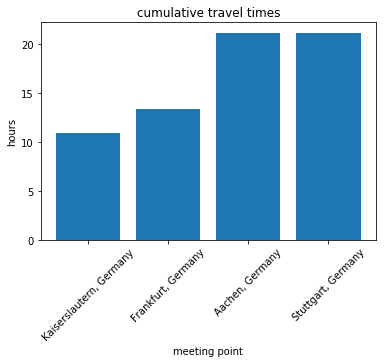

In [16]:
plt.bar(
    left=range(0, 4, 1),
    height=tt_df.time.apply(datetime.timedelta.total_seconds)/(60*60)
)
ticks = plt.xticks(range(0, 4, 1), tt_df.index, rotation=45)
max_time = max(tt_df.time.apply(datetime.timedelta.total_seconds)/(60*60))
plt.yticks(np.arange(0,max_time,5))
plt.ylabel('hours')
plt.xlabel('meeting point')
plt.title('cumulative travel times')

## Conclusion

We should meet in Kaiserslautern.

## Unless!!!

We want to weight longer trip times more heavily. That is, it's ok for everyone to travel a bit longer if it saves anyone having an excessively long trip.

We can represent this by squaring the trip time for each destination.

In [17]:
def total_travel_time_squared(destination):
    dest_times = travel_times[destination]\
                    .sort_index()\
                    .apply(datetime.timedelta.total_seconds)
    counts = homes.groupby('home').count().sort_index()
    counts.index.name = None
    person_times = (dest_times*dest_times) * counts.person
    return person_times.sum()

tt_df = pd.DataFrame(
    list(map(total_travel_time_squared, destinations)),
    index=destinations,
    columns=['time']
)
tt_df

,time
"Kaiserslautern, Germany",335568761.0
"Frankfurt, Germany",360400207.0
"Aachen, Germany",852230182.0
"Stuttgart, Germany",805194374.0


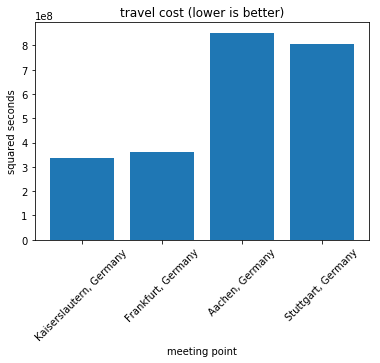

In [18]:
plt.bar(
    left=range(0, 4, 1),
    height=tt_df.time
)
ticks = plt.xticks(range(0, 4, 1), tt_df.index, rotation=45)
#plt.yticks(np.arange(0,max_time,5))
plt.ylabel('squared seconds')
plt.xlabel('meeting point')
title = plt.title('travel cost (lower is better)')

## Conclusion
We should meet in Kaiserslautern.